In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R
import matplotlib.patches as mpatches

In [9]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Utilitaires

In [2]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Data Loading

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [4]:
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"] == "jade"].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))

In [5]:
def STRUCTURE(x,y):
        return 1 - package.preprocessing.structure(x,y,is_batch = False)

metric = STRUCTURE

In [8]:
dfc_awake = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana', 'jade']) & (meta["condition"].isin(['deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_light_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana', 'jade']) & (meta["condition"].isin(['light-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_deep_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana', 'jade']) & (meta["condition"].isin(['deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_train_deep_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_train_awake = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake']))].reshape((-1, n_wins, 82, 82))
dfc_train_light_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test_deep_propofol = dfc[(meta["monkey"].isin(['jade'])) & (meta["condition"] == "deep-propofol")].reshape(-1,n_wins,82,82)
dfc_test_light_propofol = dfc[(meta["monkey"].isin(['jade'])) & (meta["condition"] == "light-propofol")].reshape(-1,n_wins,82,82)

## Basis : Deep-propofol mean states

In [6]:
mean_states = np.load("./BrainStates/deep-propofol/mean_states.npy")

FileNotFoundError: [Errno 2] No such file or directory: './BrainStates/deep-propofol/mean_states.npy'

In [ ]:
list_session_deep_propofol = np.zeros((dfc_test_deep_propofol.shape[0] + dfc_test_light_propofol.shape[0],len(mean_states)))
mean_states_ = torch.from_numpy(mean_states)
dfc_test_deep_propofol_ = torch.from_numpy(dfc_test_deep_propofol)
dfc_test_light_propofol_ = torch.from_numpy(dfc_test_light_propofol)
for i in range(len(mean_states)):
    print(i)
    for session in range(dfc_test_deep_propofol.shape[0]):
        min_val = 1
        for t in range(464):
            accu = STRUCTURE(dfc_test_deep_propofol_[session,t,:,:],mean_states_[i,:,:])
            min_val = min(accu,min_val)
        list_session_deep_propofol[session,i] = min_val
    for session in range(dfc_test_light_propofol.shape[0]):
        min_val = 1
        for t in range(464):
            accu = STRUCTURE(dfc_test_light_propofol_[session,t,:,:],mean_states_[i,:,:])
            min_val = min(accu,min_val)
        list_session_deep_propofol[dfc_test_deep_propofol.shape[0] + session,i] = min_val

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


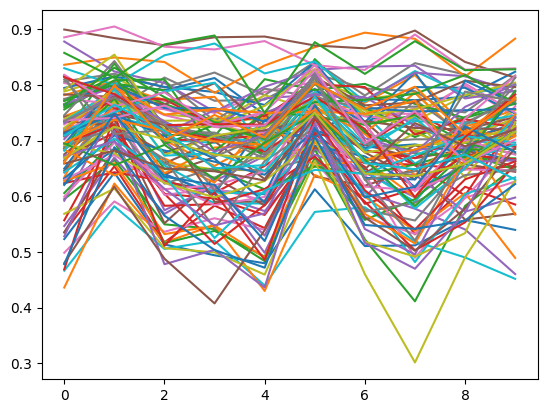

In [21]:
plt.plot(list_session_deep_propofol)
plt.show()

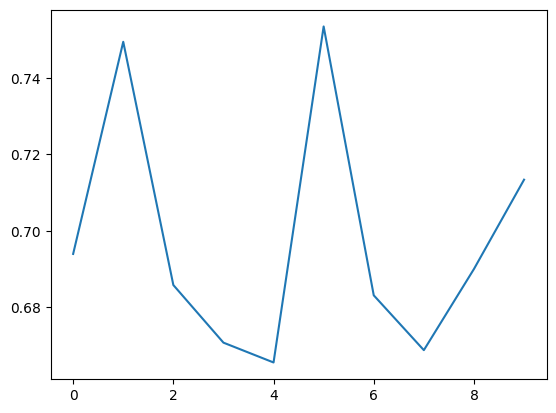

In [28]:
plt.plot(np.mean(list_session_deep_propofol,axis = 1))

## Basis : Light-propofol mean states

In [22]:
mean_states = np.load("./BrainStates/light-propofol/mean_states.npy")

In [23]:
list_session_light_propofol = np.zeros((dfc_test_deep_propofol.shape[0] + dfc_test_light_propofol.shape[0],len(mean_states)))
mean_states_ = torch.from_numpy(mean_states)
dfc_test_deep_propofol_ = torch.from_numpy(dfc_test_deep_propofol)
dfc_test_light_propofol_ = torch.from_numpy(dfc_test_light_propofol)
for i in range(len(mean_states)):
    print(i)
    for session in range(dfc_test_deep_propofol.shape[0]):
        min_val = 1
        for t in range(464):
            accu = STRUCTURE(dfc_test_deep_propofol_[session,t,:,:],mean_states_[i,:,:])
            min_val = min(accu,min_val)
        list_session_light_propofol[session,i] = min_val
    for session in range(dfc_test_light_propofol.shape[0]):
        min_val = 1
        for t in range(464):
            accu = STRUCTURE(dfc_test_light_propofol_[session,t,:,:],mean_states_[i,:,:])
            min_val = min(accu,min_val)
        list_session_light_propofol[dfc_test_deep_propofol.shape[0] + session,i] = min_val

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


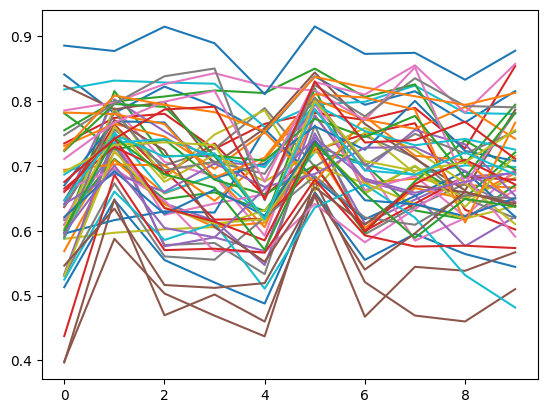

In [24]:
plt.plot(list_session_light_propofol)
plt.show()

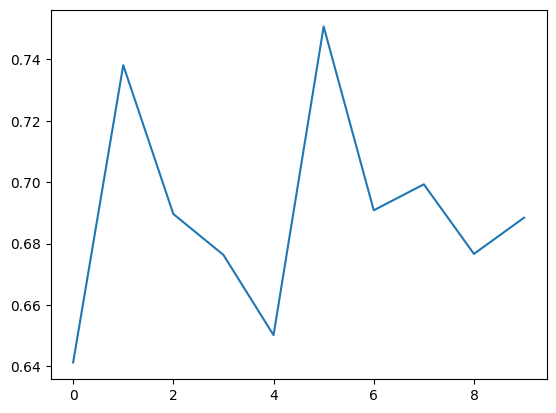

In [27]:
plt.plot(np.mean(list_session_light_propofol,axis = 1))

## Local noise

In [57]:
dfc_train_deep_propofol_tensor = torch.from_numpy(dfc_train_deep_propofol)
dfc_train_light_propofol_tensor = torch.from_numpy(dfc_train_light_propofol)
dfc_train_awake_tensor = torch.from_numpy(dfc_train_awake)

In [116]:
tab_awake = np.zeros((dfc_train_awake_tensor.shape[0],dfc_train_awake_tensor.shape[1]))
for k in range(dfc_train_awake_tensor.shape[0]):
    for i in range(dfc_train_awake_tensor.shape[1]):
        tab_awake[k,i] = package.preprocessing.local_noise(dfc_train_awake_tensor[k,i,:,:]).item()

In [117]:
tab_deep_propofol = np.zeros((dfc_train_deep_propofol_tensor.shape[0],dfc_train_deep_propofol_tensor.shape[1]))
for k in range(dfc_train_deep_propofol_tensor.shape[0]):
    for i in range(dfc_train_deep_propofol_tensor.shape[1]):
        tab_deep_propofol[k,i] = package.preprocessing.local_noise(dfc_train_deep_propofol_tensor[k,i,:,:]).item()

In [118]:
tab_light_propofol = np.zeros((dfc_train_light_propofol_tensor.shape[0],dfc_train_light_propofol_tensor.shape[1]))
for k in range(dfc_train_light_propofol_tensor.shape[0]):
    for i in range(dfc_train_light_propofol_tensor.shape[1]):
        tab_light_propofol[k,i] = package.preprocessing.local_noise(dfc_train_light_propofol_tensor[k,i,:,:]).item()

In [62]:
tab_awake.shape

(13, 464)

In [119]:
np.mean(tab_awake,axis = 1)

array([0.16704962, 0.15876765, 0.13013627, 0.12870282, 0.07652332,
       0.0810752 , 0.08589841, 0.07942334, 0.07788515, 0.09477721,
       0.12302536, 0.1522388 , 0.12074579])

In [120]:
np.mean(tab_light_propofol,axis = 1)

array([0.06563023, 0.06157143, 0.05892255, 0.06288469, 0.05699433,
       0.08086924, 0.06373956, 0.05963468, 0.05722536, 0.06018843,
       0.05888352, 0.09678742, 0.09628183, 0.08208078, 0.1057035 ,
       0.06661223, 0.0627387 , 0.06754118, 0.07698405, 0.05663378,
       0.06709511, 0.0643923 , 0.06798479])

In [122]:
np.max(tab_deep_propofol,axis = 1)

array([0.09090097, 0.09920263, 0.12132848, 0.09339338, 0.13975   ,
       0.20086827, 0.10901663, 0.10631983, 0.10268195, 0.13070765,
       0.11569599, 0.10365016, 0.10313783, 0.1056947 , 0.11756528,
       0.11109794, 0.11664245, 0.12552168, 0.09623365, 0.1030705 ,
       0.12466567, 0.13113678])

In [131]:
np.sum(tab_light_propofol > 0.06,axis = 1)

array([287, 218, 196, 245, 148, 442, 265, 193, 144, 220, 173, 445, 437,
       362, 426, 330, 250, 334, 391, 148, 313, 287, 282])

In [132]:
np.sum(tab_deep_propofol > 0.06,axis = 1)

array([218, 275, 236, 268, 304, 359, 453, 221, 228, 288, 346, 378, 334,
       303, 355, 298, 298, 387, 236, 315, 387, 433])

In [121]:
np.mean(tab_deep_propofol,axis = 1)

array([0.0614879 , 0.06281145, 0.06294112, 0.06263337, 0.07038615,
       0.08188112, 0.07831472, 0.06138334, 0.06131715, 0.06775811,
       0.06990809, 0.06985955, 0.06893988, 0.06670676, 0.07101887,
       0.06568157, 0.06724891, 0.07322785, 0.06230596, 0.06831455,
       0.07427287, 0.07625096])

In [113]:
dfc_train_deep_propofol_tensor.shape

torch.Size([22, 464, 82, 82])

0.06819031730072543


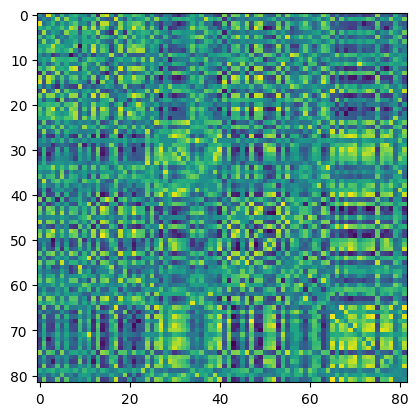

0.06515972339371752


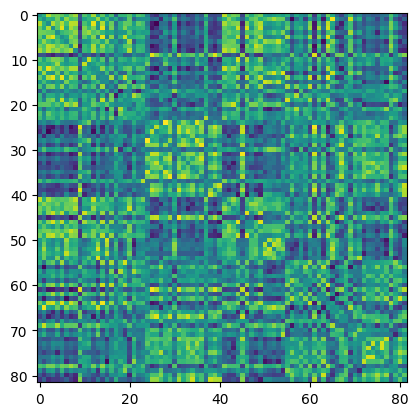

0.06170147443764185


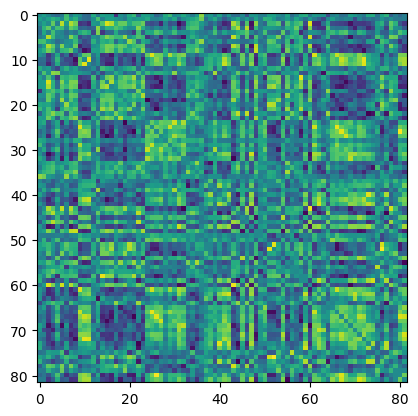

0.06336559829367429


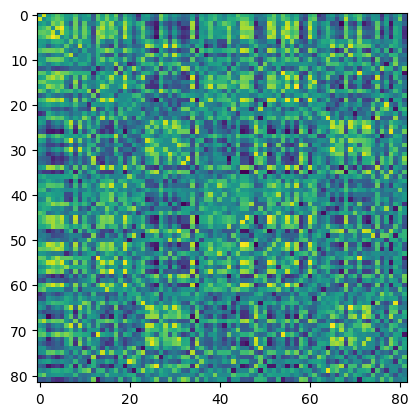

0.10548841864499084


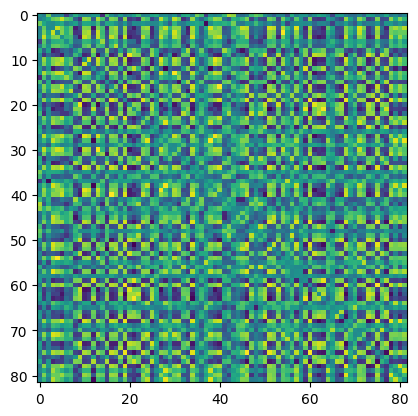

0.12041256175606002


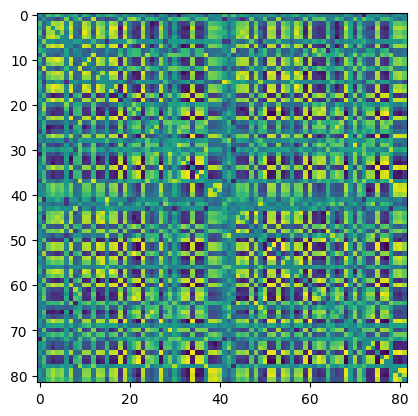

0.08403525890527029


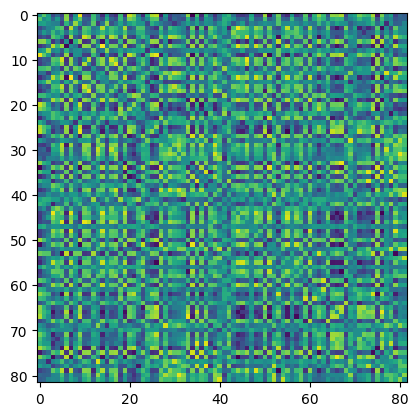

0.060053995193834885


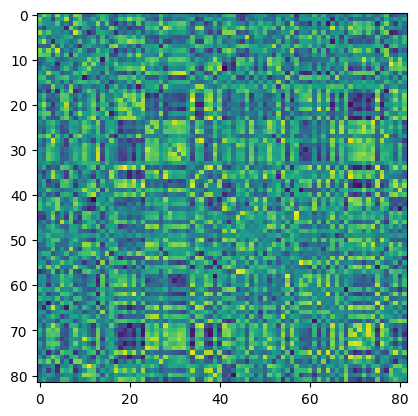

0.07251295311598183


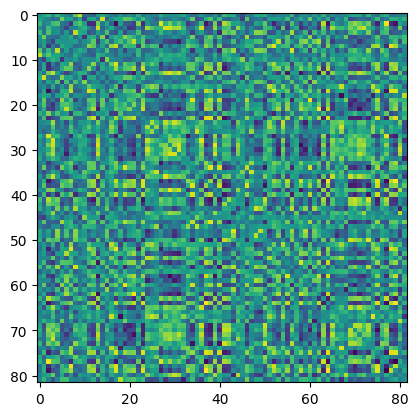

In [130]:
for i in np.random.randint(0,22,3):
    for j in np.random.randint(0,464,3):
        print(package.preprocessing.local_noise(dfc_train_deep_propofol_tensor[i,j,:,:]).item())
        plt.imshow(dfc_train_deep_propofol[i,j,:,:])
        plt.show()

## Cebra on deep vs light

In [7]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1}

In [8]:
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

In [9]:
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

In [10]:
#We define the architecture of the model we will use

num_output = 6
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Dropout(0),
    nn.Linear(
        num_neurons,
        1000,
    ),
    nn.ReLU(),
    nn.Linear(
        1000,
        500,
    ),
    nn.ReLU(),
    nn.Linear(
        500,
        100,
    ),
    nn.ReLU(),
    nn.Linear(
        100,
        50,
    ),
    nn.ReLU(),
    nn.Linear(
        50,
        20,
    ),
    nn.ReLU(),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [11]:
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
discrete = labels_train

In [12]:
fc_train = torch.squeeze(fc_train,dim=2)
fc_train_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_train))
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 6000,  time_delta = 5, matrix_delta = 0.5)

In [13]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [14]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 8.6995, Train accuracy 0.00%
Epoch 100
Train loss 8.1010, Train accuracy 0.00%
Epoch 200
Train loss 8.0973, Train accuracy 0.00%
Epoch 300
Train loss 8.0986, Train accuracy 0.00%


KeyboardInterrupt: 

/tmp/ipykernel_15154/3321132120.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


(-1.0084934562444687,
 1.088089320063591,
 -1.0999831825494766,
 1.0999903947114944)

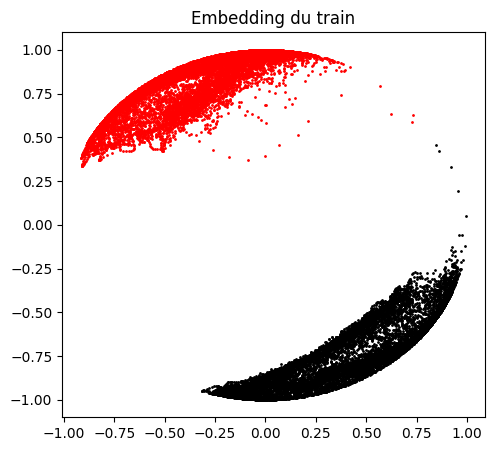

In [16]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red']
for i in range(45):
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

In [17]:
dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
dfc_test_vector = dfc_test_vector.type(torch.float32)

In [18]:
#dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
a,b,c = dfc_test_vector.shape
data = dfc_test_vector.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)

/tmp/ipykernel_15154/2790757100.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)


(-0.9468520820140839,
 1.0925308406352996,
 -1.0995038479566575,
 1.0992070764303208)

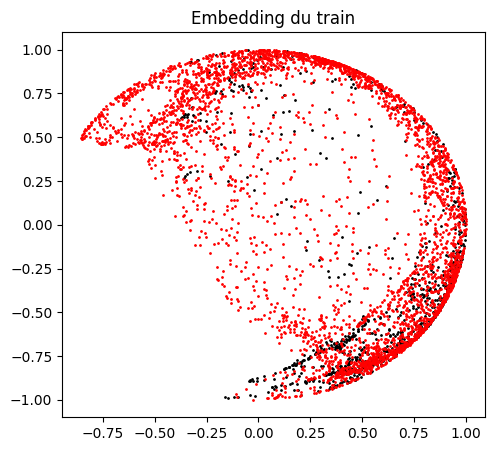

In [23]:
a,b,c = dfc_test_vector.shape
data = dfc_test_vector.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple','yellow']
for i in range(10):
    if labels_test[i,0] in [0,1,2]:
        ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

## Continuity

In [6]:
dfc_train_deep_propofol_tensor = torch.from_numpy(dfc_train_deep_propofol)
dfc_train_light_propofol_tensor = torch.from_numpy(dfc_train_light_propofol)
dfc_train_awake_tensor = torch.from_numpy(dfc_train_awake)

In [7]:
tab_awake = package.preprocessing.stable_distance(dfc_train_awake_tensor,threshold = 0.8)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [8]:
tab_light_propofol = package.preprocessing.stable_distance(dfc_train_light_propofol_tensor,threshold = 0.8)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [9]:
tab_deep_propofol = package.preprocessing.stable_distance(dfc_train_deep_propofol_tensor,threshold = 0.8)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


(array([  26.,   14.,  874., 1212., 2111.,  607.,  655.,  153.,  174.,
          54.,   29.,   44.,   22.,   25.,    4.,   11.,    4.,    6.,
           3.,    4.]),
 array([ 1.        ,  2.45000005,  3.9000001 ,  5.3499999 ,  6.80000019,
         8.25      ,  9.69999981, 11.14999962, 12.60000038, 14.05000019,
        15.5       , 16.95000076, 18.39999962, 19.85000038, 21.29999924,
        22.75      , 24.20000076, 25.64999962, 27.10000038, 28.54999924,
        30.        ]),
 <BarContainer object of 20 artists>)

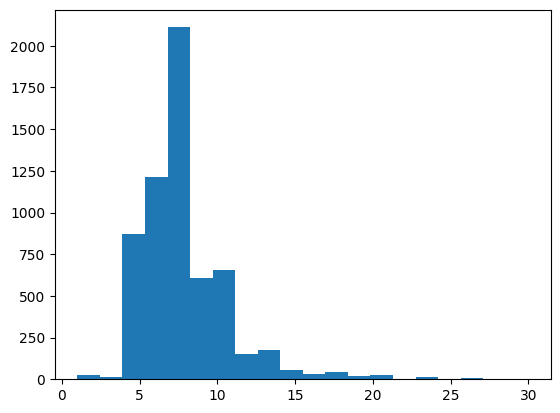

In [10]:
plt.hist(tab_awake.flatten(),bins = 20)

(array([2.300e+01, 2.300e+01, 2.400e+01, 2.540e+02, 0.000e+00, 2.476e+03,
        3.878e+03, 2.130e+03, 7.970e+02, 0.000e+00, 3.960e+02, 2.400e+02,
        1.420e+02, 9.500e+01, 0.000e+00, 5.200e+01, 5.300e+01, 4.000e+01,
        2.300e+01, 0.000e+00, 8.000e+00, 5.000e+00, 5.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.        ,  1.79999995,  2.5999999 ,  3.4000001 ,  4.19999981,
         5.        ,  5.80000019,  6.5999999 ,  7.4000001 ,  8.19999981,
         9.        ,  9.80000019, 10.60000038, 11.39999962, 12.19999981,
        13.        , 13.80000019, 14.60000038, 15.39999962, 16.20000076,
        17.        , 17.79999924, 18.60000038, 19.39999962, 20.20000076,
        21.        , 21.79999924, 22.60000038, 23.39999962, 24.20000076,
        25.        ]),
 <BarContainer object of 30 artists>)

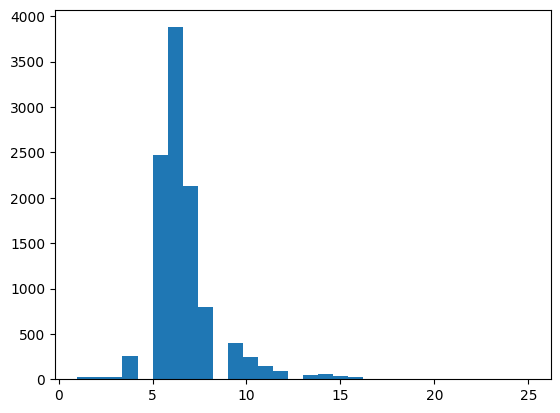

In [12]:
plt.hist(tab_light_propofol.flatten(),bins = 30)

(array([2.200e+01, 2.200e+01, 2.300e+01, 2.730e+02, 2.284e+03, 3.646e+03,
        2.204e+03, 1.008e+03, 4.460e+02, 1.510e+02, 7.400e+01, 2.200e+01,
        1.800e+01, 5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 3.000e+00]),
 array([ 1.        ,  1.95000005,  2.9000001 ,  3.8499999 ,  4.80000019,
         5.75      ,  6.69999981,  7.6500001 ,  8.60000038,  9.55000019,
        10.5       , 11.44999981, 12.39999962, 13.35000038, 14.30000019,
        15.25      , 16.20000076, 17.14999962, 18.10000038, 19.04999924,
        20.        ]),
 <BarContainer object of 20 artists>)

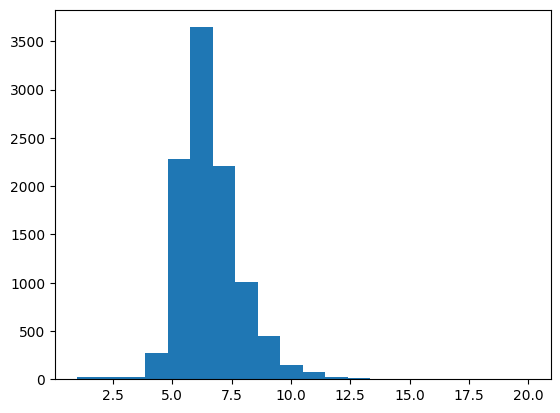

In [14]:
plt.hist(tab_deep_propofol.flatten(),bins = 20)

## Cebra with continuity

In [9]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1}

In [10]:
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

In [11]:
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

In [12]:
#We define the architecture of the model we will use

num_output = 6
normalize = True
num_neurons = 19926

model = cebra2.model.Model(
    nn.Dropout(0),
    nn.Linear(
        num_neurons,
        5000,
    ),
    nn.Linear(
        5000,
        1000,
    ),
    nn.Linear(
        1000,
        200,
    ),
    nn.Linear(
        200,
        50,
    ),
    nn.Linear(
        50,
        20,
    ),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [136]:
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
fc_test = torch.from_numpy(dfc_test.reshape((dfc_test.shape[0],464,1,82,82)))

In [108]:
fc_train_cat.shape

torch.Size([45, 459, 19926])

In [107]:
fc_train = torch.squeeze(fc_train,dim=2)
fc_train_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_train))
fc_train_cat = torch.cat([fc_train_vector[:,:-5,:],fc_train_vector[:,1:-4,:],fc_train_vector[:,2:-3,:],fc_train_vector[:,3:-2,:],fc_train_vector[:,4:-1,:],fc_train_vector[:,5:,:]],dim = 2)
discrete = labels_train[:,:-5]
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_cat,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 6000,  time_delta = 5, matrix_delta = 0.5)

In [137]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [138]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 8.6987, Train accuracy 0.00%
Epoch 100
Train loss 8.1047, Train accuracy 0.00%


KeyboardInterrupt: 

/tmp/ipykernel_21348/4089179348.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


(-0.9294003337621689, 0.9403174608945847, -1.09967540204525, 1.09534053504467)

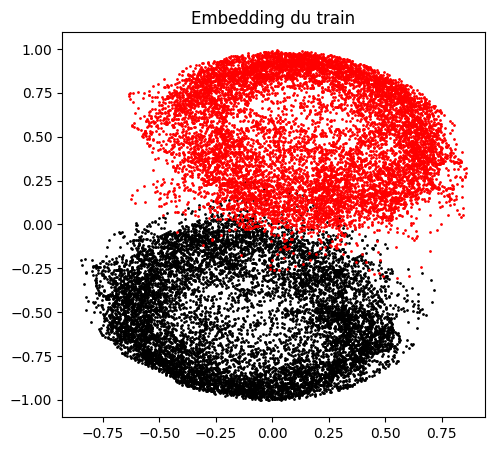

In [112]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red']
for i in range(45):
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

In [115]:
fc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
fc_test_vector = fc_test_vector.type(torch.float32)
fc_test_cat = torch.cat([fc_test_vector[:,:-5,:],fc_test_vector[:,1:-4,:],fc_test_vector[:,2:-3,:],fc_test_vector[:,3:-2,:],fc_test_vector[:,4:-1,:],fc_test_vector[:,5:,:]],dim = 2)

/tmp/ipykernel_21348/3096312119.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)


IndexError: index 10 is out of bounds for axis 0 with size 10

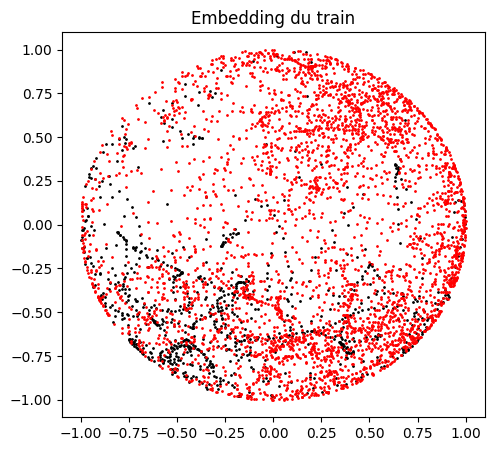

In [118]:
#dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
a,b,c = fc_test_cat.shape
data = fc_test_cat.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red']
for i in range(30):
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

In [127]:
net = package.torch_classifier.MLP(input_dim = 3,output_dim = 2)
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
X = fc_emb.reshape((-1,3))
y = labels_train[:,:-5].reshape((-1))
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 2, n_samples = 1000)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True, num_workers=6)

In [89]:
import importlib
importlib.reload(package.torch_classifier)

<module 'package.torch_classifier' from '/volatile/aurelien_stumpf_mascles/project/code/package/torch_classifier.py'>

In [128]:
package.torch_classifier.Train(net,train_loader,test_loader,100,lr = 0.01)

Train loss 0.6912, Train accuracy 50.00%
Test accuracy 51.61%
Train loss 0.1050, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0064, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0027, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0016, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0011, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0009, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0007, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0006, Train accuracy 100.00%
Test accuracy 99.88%
Train loss 0.0005, Train accuracy 100.00%
Test accuracy 99.88%
End of training.



(-1.1, 1.1, -1.0999848204440221, 1.0999848204440221)

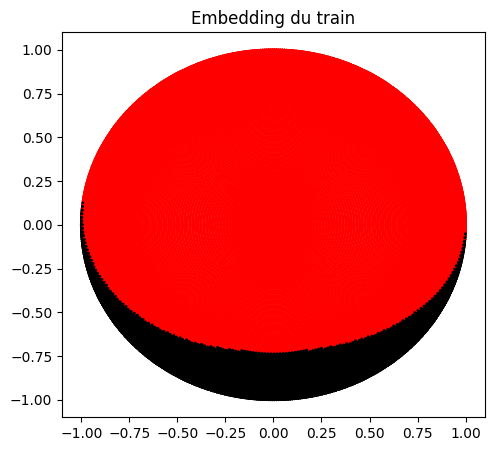

In [129]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,300),np.linspace(0,np.pi,200))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

net.eval()
probas = torch.exp(net(torch.from_numpy(sphere).type(torch.float32)))
res = torch.argmax(probas,dim=1)

fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red']
ax1.scatter(sphere[:,0], sphere[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = res, s=1)
#ax1.xticks() 
ax1.axis('on')

In [130]:
net.eval()
for session in range(10):
    probas = torch.zeros((2))
    a,b,c = fc_test_cat.shape
    data = fc_test_cat[session,:,:]
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, data))
    probas = torch.sum(torch.exp(net(emb.type(torch.float32))),dim=0)
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_test[session,0],res,probas.detach().numpy()))

True label : 0, Predicted label : 0, Probas : [385.80106  73.19892]
True label : 0, Predicted label : 0, Probas : [410.95285  48.04716]
True label : 1, Predicted label : 0, Probas : [374.20813  84.79187]
True label : 1, Predicted label : 0, Probas : [250.53146 208.46854]
True label : 1, Predicted label : 1, Probas : [217.35129 241.64871]
True label : 1, Predicted label : 0, Probas : [257.6371  201.36292]
True label : 1, Predicted label : 0, Probas : [329.39813 129.6019 ]
True label : 1, Predicted label : 1, Probas : [217.23813 241.76187]
True label : 1, Predicted label : 1, Probas : [174.49516 284.50482]
True label : 1, Predicted label : 0, Probas : [326.31116 132.68884]


## Cebra again

In [6]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1}

In [7]:
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

In [8]:
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

In [23]:
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
fc_test = torch.from_numpy(dfc_test.reshape((dfc_test.shape[0],464,1,82,82)))

#Keep only the higher triangular
fc_train = torch.squeeze(fc_train,dim=2)
fc_test = torch.squeeze(fc_test,dim=2)
fc_train_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_train))
fc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_test))

#Reduce dimensions with PCA
a,b,c = fc_train_vector.shape
e,f,g = fc_test_vector.shape
pca = PCA(n_components=200)
pca.fit(fc_train_vector.reshape(a*b,c))
fc_train_vector_reduced = np.zeros((a,b,200))
fc_test_vector_reduced = np.zeros((e,f,200))
for i in range(a):
    fc_train_vector_reduced[i,:,:] = pca.transform(fc_train_vector[i,:,:])
for j in range(e):
    fc_test_vector_reduced[j,:,:] = pca.transform(fc_test_vector[j,:,:])
fc_train_vector_reduced = torch.from_numpy(fc_train_vector_reduced)
fc_test_vector_reduced = torch.from_numpy(fc_test_vector_reduced)

discrete = labels_train
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector_reduced,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 2000,  time_delta = 5)


In [24]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 200

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        20,
    ),
    nn.Dropout(0.3),
    nn.GELU(),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [26]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.0564, Train accuracy 0.00%
Epoch 100
Train loss 7.0480, Train accuracy 0.00%
Epoch 200
Train loss 7.0427, Train accuracy 0.00%
Epoch 300
Train loss 7.0497, Train accuracy 0.00%
Epoch 400
Train loss 7.0384, Train accuracy 0.00%
Epoch 500
Train loss 7.0418, Train accuracy 0.00%
Epoch 600
Train loss 7.0315, Train accuracy 0.00%
Epoch 700
Train loss 7.0301, Train accuracy 0.00%
Epoch 800
Train loss 7.0244, Train accuracy 0.00%
Epoch 900
Train loss 7.0245, Train accuracy 0.00%


/tmp/ipykernel_12702/1768848569.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


'\nblack_patch = mpatches.Patch(color=\'black\', label=\'light-propofol\')\nred_patch = mpatches.Patch(color=\'red\', label=\'deep-propofol\')\nax1.legend(loc = "upper left",handles=[black_patch,red_patch])\n'

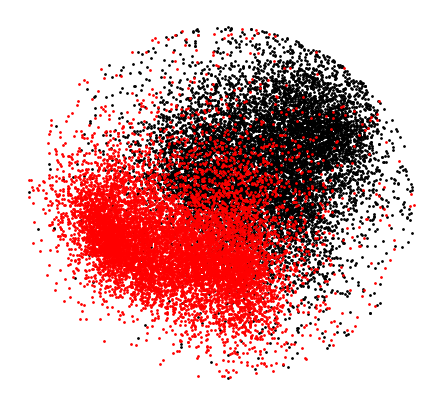

In [51]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red']
for i in range(45):
    ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')
"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
ax1.legend(loc = "upper left",handles=[black_patch,red_patch])
"""

/tmp/ipykernel_12702/1291324894.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)


'\nblack_patch = mpatches.Patch(color=\'black\', label=\'light-propofol\')\nred_patch = mpatches.Patch(color=\'red\', label=\'deep-propofol\')\nax1.legend(loc = "upper left",handles=[black_patch,red_patch])\n'

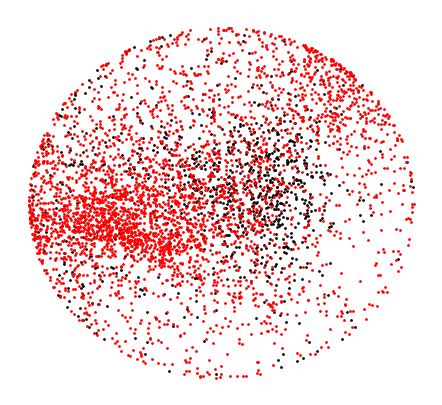

In [50]:
#dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
a,b,c = fc_test_vector_reduced.shape
data = fc_test_vector_reduced.resize(a*b,c).type(torch.float32)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red']
for i in range(10):
    ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')
"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
ax1.legend(loc = "upper left",handles=[black_patch,red_patch])
"""

In [30]:
net = package.torch_classifier.MLP(input_dim = 3,output_dim = 2)
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
X = fc_emb.reshape((-1,3))
y = labels_train.reshape((-1))
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 2, n_samples = 1000)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=6)

In [31]:
package.torch_classifier.Train(net,train_loader,test_loader,100,lr = 0.01)

Train loss 0.6526, Train accuracy 89.93%
Test accuracy 98.79%
Train loss 0.0249, Train accuracy 99.59%
Test accuracy 98.98%
Train loss 0.0168, Train accuracy 99.61%
Test accuracy 98.98%
Train loss 0.0145, Train accuracy 99.64%
Test accuracy 98.98%


KeyboardInterrupt: 

(-1.1, 1.1, -1.0999848204440221, 1.0999848204440221)

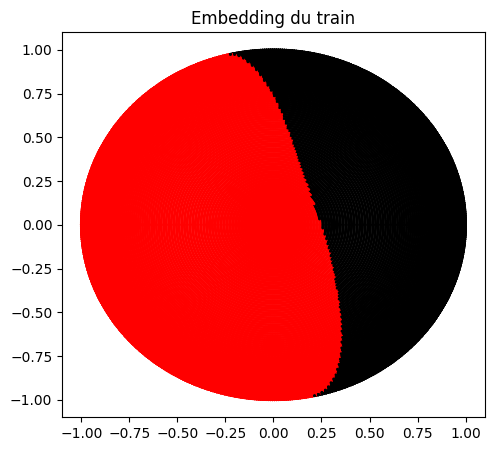

In [32]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,300),np.linspace(0,-np.pi,200))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

net.eval()
probas = torch.exp(net(torch.from_numpy(sphere).type(torch.float32)))
res = torch.argmax(probas,dim=1)

fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red']
ax1.scatter(sphere[:,0], sphere[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = res, s=1)
#ax1.xticks() 
ax1.axis('on')

In [34]:
net.eval()
for session in range(10):
    probas = torch.zeros((2))
    a,b,c = fc_test_vector_reduced.shape
    data = fc_test_vector_reduced[session,:,:].type(torch.float32)
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, data))
    probas = torch.sum(torch.exp(net(emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_test[session,0],res,probas.detach().numpy()))

True label : 0, Predicted label : 0, Probas : [0.82380587 0.1761942 ]
True label : 0, Predicted label : 0, Probas : [0.864797 0.135203]
True label : 1, Predicted label : 0, Probas : [0.5246349  0.47536507]
True label : 1, Predicted label : 1, Probas : [0.2711227 0.7288773]
True label : 1, Predicted label : 1, Probas : [0.24809155 0.7519085 ]
True label : 1, Predicted label : 1, Probas : [0.20876794 0.79123205]
True label : 1, Predicted label : 1, Probas : [0.34601438 0.6539856 ]
True label : 1, Predicted label : 1, Probas : [0.25318488 0.74681515]
True label : 1, Predicted label : 1, Probas : [0.23410477 0.7658952 ]
True label : 1, Predicted label : 0, Probas : [0.52311385 0.47688615]


In [74]:
net.eval()
accu = torch.zeros(3)
for session in range(2,10):
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, fc_test_vector[session,:,:].type(torch.float32)))
    probas = torch.sum(torch.exp(net(emb.type(torch.float32))),dim=0)
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print(accu/8)

tensor([0.2500, 0.7500, 0.0000])
